# Predicting Pulsar Stars Using Machine Learning Techniques
## Logistic Regression, Support Vector Machine, K Nearest Neighbors, Neural Networks & Random Forest
## Javier Urrecha, Raúl González y Mario Aviles
### December 10th, 2019

## 1. Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from sklearn.metrics import confusion_matrix, roc_curve, auc, log_loss
from sklearn import metrics
import sklearn.metrics as skm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from sklearn.ensemble import RandomForestClassifier

Using TensorFlow backend.


## 2. Defining functions

### Inner product
$$θ=w^TX$$

In [2]:
def theta(w, x):
    
    """
        params:
            w: [np_array] a vector of weights with dimensions (nx1), where n represents the number of weights.
            x: [np_array] a matrix of feature variables with dimensions (nxm), 
                where n represents the number of feature variables and m the number of training examples
        returns:
            theta: [np_array] a vector of the inner product of w and x with dimensions (1xm)
    """
        
    return w.T.dot(x)

### Logistic Regression hypothesis
$$h_w(x)=g(w^TX)=\frac{1}{1+e^{-w^TX}}$$

In [3]:
def sigmoid(z):
    
    """
        params:
            z: [np_array] a vector of the inner product of w and x with dimensions (1xm)
        returns:
            sigmoid: [np_array] a vector of the estimations performed by the model
    """
    
    return (1/(1+np.exp(-z)))

### Logistic Regression Log Loss 
$$J(w)=-\sum_{i=1}^{m}y^{(i)}\log h_w(x^{(i)}) +(1-y^{(i)})\log(1-h_w(x^{(i)}))$$

In [4]:
def J(w, x, y):
    """
        params:
            w: [np_array] a vector of weights with dimensions (nx1), where n represents the number of weights.
            x: [np_array] a matrix of feature variables with dimensions (nxm), 
                where n represents the number of feature variables and m the number of training examples
            y: [np_array] a vector of target variables with dimensions (mx1), 
                where m represents the number of target variables
        returns:
            J: [double] the loss function
    """
    
    z=theta(w,x)
    h=sigmoid(z)
    return (1/(x.shape[1]))*np.sum((-y * np.log(h) - (1 - y) * np.log(1 - h)))

### Log Loss Gradient
$$\frac{\delta }{\delta w_j}J(w)=(y-h_w(x))x_j$$

In [5]:
def dJ(w, x, y):
    
    """
        params:
            w: [np_array] a vector of weights with dimensions (nx1), where n represents the number of weights.
            x: [np_array] a matrix of feature variables with dimensions (nxm), 
                where n represents the number of feature variables and m the number of training examples
            y: [np_array] a vector of target variables with dimensions (mx1), 
                where m represents the number of target variables
        returns:
            dJ: [double] the derivative of the loss function
    """

    z=theta(w,x)
    e = sigmoid(z).T - y
    
    return (1 / (x.shape[1]))*(np.dot(x, e))

### Gradient Descent
$$w:= w-\alpha \nabla_wJ(w)$$

In [6]:
def optimizar_LMS(x_train, y_train, x_test, y_test, num_iter, alpha, w=None):

    """
        We calculate gradient descent for minimizing the MSE to obtain the best linear hypothesis.
            params:
                x_train: [np_array] a matrix of feature variables with dimensions (nxm), 
                    where n represents the number of feature variables and m the number of training examples
                x_test: [np_array] a matrix of feature variables with dimensions (nxm), 
                    where n represents the number of feature variables and m the number of validating examples
                y_train: [np_array] a vector of target variables with dimensions (mx1), 
                    where m represents the number of training target variables
                y_test: [np_array] a vector of target variables with dimensions (mx1), 
                    where m represents the number of validating target variables
                num_iter: [int] an integer indicating the number of iterations of the Gradient Descent algorithm
                alpha: [double] learning rate constant specifying the magnitude update step
                w: [np_array] vector that contains the initial weights to start optimzing the model with dimensions (n x 1)

            return:
                J_train: [np_array] a vector (num_iter x 1) containing all cost function evaluations during training
                J_test: [np_array] a vector (num_iter x 1) containing all cost function evaluations during training
                w: [np_array] a vector of the final optimized weights with dimensions (nx1)
    """

    if w is None:
        # Inicializamos los pesos aleatoriamente
        w = np.random.randn(x_train.shape[0], 1)

    # se generan los vectores
    it = np.arange(0, num_iter)
    J_train = np.zeros(num_iter)
    J_test = np.zeros(num_iter)

    # Se optimiza el modelo por el numero de iteraciones
    for i in range(num_iter):

        # Actualizamos los pesos
        w = w - alpha * dJ(w, x_train, y_train)

        # Guardamos los costo
        J_train[i] = J(w, x_train, y_train)

        J_test[i] = J(w, x_test, y_test)

    return w, J_train, J_test

### Probability function

In [7]:
def proba(w,x):
    """
        params:
            w: [np_array] a vector of weights with dimensions (nx1), where n represents the number of weights.
            x: [np_array] a matrix of feature variables with dimensions (nxm), 
                where n represents the number of feature variables and m the number of training examples
        returns:
            probability: [np_array] a vector with the probabilities of belonging to class 1, with dimensions (1xm)
    """
    proba=np.zeros(x.shape[1])
    n=0
    for i in range(0,x.shape[1]):
        y_hat = sigmoid(theta(w, x[:,i]))
        proba[n]=y_hat
        n+=1

    return proba

### Classification function

In [8]:
def classify(w,x_test,porcentaje):
    """
        params:
            w: [np_array] a vector of weights with dimensions (nx1), where n represents the number of weights.
            x: [np_array] a matrix of feature variables with dimensions (nxm), 
                where n represents the number of feature variables and m the number of training examples
        returns:
            prediction: [np_array] a vector with the predicted classes, with dimensions (1xm)
    """
    prediction = []
    for i in range(0,x_test.shape[1]):
        y_hat = sigmoid(theta(w, x_test[:,i]))           
        if y_hat>porcentaje:
            prediction.append(1)
        else:
            prediction.append(0)
    return prediction

### Normalization function

In [9]:
def norm(arr,min,max):
    
    """
        params:
            arr: [np_array] a vector of training/validating examples with dimensions (mx1), 
            where m represents the number training or validating examples
            min: [double] the minimum value of the array
            max: [double] the maximum value of the array  
        returns:
            normalization: [np_array] the normalized vector (mx1)
    """
    return (arr - min) / (max - min)
    

## 3. Importing datasets, balancing and normalazing

In [10]:
# Indicamos la dirección y nombre del archivo y se imprime la cabecera
data = pd.read_csv('HTRU_2.csv')
data.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [11]:
#Se imprimen las dimensiones del conjunto de datos
print('Data shape\n',data.shape)

Data shape
 (17898, 9)


In [12]:
#Se utiliza la función train_test_split para separar los datos en 70% de entrenamiento y 30% de validación
data_train , data_test = train_test_split(data,test_size = .3,random_state = 100)


print('Training data shape\n',data_train.shape)
print('\nTesting data shape\n',data_test.shape)

Training data shape
 (12528, 9)

Testing data shape
 (5370, 9)


In [13]:
#Se seleccionan las primeras ocho columnas para las características y la última columna para la clase,
#tanto en entrenamiento como en validación
X_train = data_train[[x for x in data_train.columns if x not in ["target_class"]]]
Y_train = data_train[["target_class"]]
X_test  = data_test[[x for x in data_test.columns if x not in ["target_class"]]]
Y_test  = data_test[["target_class"]]

print('Training features shape\n',X_train.shape)
print('\nTraining target shape\n',Y_train.shape)
print('\nTesting features shape\n',X_test.shape)
print('\nTesting target shape\n',Y_test.shape)

Training features shape
 (12528, 8)

Training target shape
 (12528, 1)

Testing features shape
 (5370, 8)

Testing target shape
 (5370, 1)


Class 0: 11385
Class 1: 1143
Proportion: 9.96 : 1


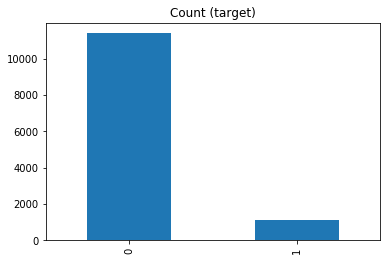

In [14]:
#Se cuentan los datos de la clase para ver si el conjunto de entrenamiento de la clase está balanceado
target_count = Y_train.target_class.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
target_count.plot(kind='bar', title='Count (target)');

In [15]:
#Se convierten los conjuntos de entrenamiento en vectores
X_train_list = X_train.values.tolist()
X_train = np.array(X_train_list, dtype='float64')
print(X_train.shape)
print(type(X_train))

Y_train_list = Y_train.values.tolist()
Y_train = np.array(Y_train_list, dtype='float64')
print(Y_train.shape)
print(type(Y_train))

(12528, 8)
<class 'numpy.ndarray'>
(12528, 1)
<class 'numpy.ndarray'>


In [16]:
#Se utiliza la función SMOTEEEN para balancear los datos de entrenamiento
smote_enn = SMOTEENN(random_state=0)
X_train_res, Y_train_res = smote_enn.fit_resample(X_train, Y_train)

C:\Users\Raul Gonzalez\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class 0: 10014
Class 1: 10835
Proportion: 0.92 : 1


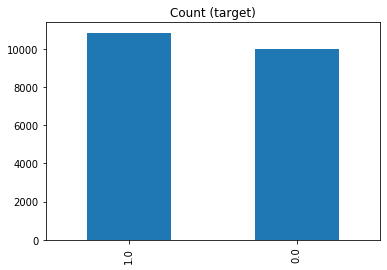

In [17]:
#Se verifica que los datos de entrenamiento estén balanceados
Y_train_res=pd.DataFrame(Y_train_res, columns=['target_class'])
target_count_res = Y_train_res.target_class.value_counts()
print('Class 0:', target_count_res[0])
print('Class 1:', target_count_res[1])
print('Proportion:', round(target_count_res[0] / target_count_res[1], 2), ': 1')

target_count_res.plot(kind='bar', title='Count (target)');

In [18]:
#Se imprime el tipo y dimensiones de los conjuntos
print(Y_train_res.shape)
print(X_train_res.shape)
print(type(Y_train_res))
print(type(X_train_res))

(20849, 1)
(20849, 8)
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [19]:
#Se convierten los conjuntos en vectores
Y_train_list = Y_train_res.values.tolist()

y_train = np.array(Y_train_list, dtype='float64')

x_train=X_train_res

print(x_train.shape)
print(y_train.shape)
print(type(y_train))

(20849, 8)
(20849, 1)
<class 'numpy.ndarray'>


In [20]:
#Se convierten los conjuntos de validación en vectores
X_test_list = X_test.values.tolist()
X_test = np.array(X_test_list, dtype='float64')
x_test=X_test
print(x_test.shape)
print(type(x_test))


Y_test_list = Y_test.values.tolist()
Y_test = np.array(Y_test_list, dtype='float64')
y_test=Y_test
print(y_test.shape)
print(type(y_test))

(5370, 8)
<class 'numpy.ndarray'>
(5370, 1)
<class 'numpy.ndarray'>


In [21]:
#Se normalizan los conjuntos de datos de características
x_train_norm = np.zeros((x_train.shape[0],x_train.shape[1]))
x_test_norm = np.zeros((x_test.shape[0],x_test.shape[1]))

for i in range (0,x_train.shape[1]):
    x_train_norm[:,i]=norm(x_train[:,i],min(x_train[:,i]), max(x_train[:,i]))
    
for i in range (0,x_test.shape[1]):
    x_test_norm[:,i]=norm(x_test[:,i],min(x_train[:,i]), max(x_train[:,i]))

In [22]:
print(x_train_norm)
print(x_test_norm)

[[0.58307892 0.28067169 0.21173358 ... 0.59931604 0.15051058 0.00538666]
 [0.55426373 0.19049382 0.20553339 ... 0.0490563  0.40856306 0.16046392]
 [0.5369077  0.23974651 0.24268133 ... 0.0944188  0.32870794 0.08365848]
 ...
 [0.30431934 0.22046213 0.4154943  ... 0.33760671 0.19023258 0.01509734]
 [0.08556533 0.20065443 0.64736297 ... 0.65557516 0.08399583 0.00078449]
 [0.51801376 0.30679789 0.24278695 ... 0.65794871 0.11994746 0.00189978]]
[[0.58123876 0.14939957 0.23421148 ... 0.05359629 0.37712398 0.14024695]
 [0.53448204 0.29425281 0.22322145 ... 0.14229973 0.28370677 0.05190835]
 [0.58370624 0.43302787 0.19818329 ... 0.52204571 0.0497964  0.00147159]
 ...
 [0.37560119 0.25727772 0.27537442 ... 0.15452032 0.28973011 0.05426537]
 [0.50198653 0.29075309 0.25006323 ... 0.34093246 0.18562476 0.0132561 ]
 [0.4934549  0.2494336  0.22766679 ... 0.0555486  0.42695732 0.1622515 ]]


## 4. Creating the algorithms

## Logistic Regression from 0

In [23]:
#Se añade la unidad de sesgo
x_train_norm_b = np.insert(x_train_norm, 0, 1, axis=1)
x_train_norm_b = x_train_norm_b.T

print(x_train_norm_b.shape)

x_test_norm_b = np.insert(x_test_norm, 0, 1, axis=1)
x_test_norm_b = x_test_norm_b.T
print(x_test_norm_b.shape)

(9, 20849)
(9, 5370)


In [24]:
# Se asigna un vector w arbitrario
w0=1
w1 = -0.1
w2 = -0.1
w3 = 3
w4 = -0.3
w5 = -0.03
w6 = 0.03
w7 = -0.03
w8 = -0.0001

w = np.array([w0,w1, w2, w3, w4, w5, w6, w7, w8], dtype='float64')
w = w.reshape((w.shape[0], 1))
print('w shape\n',w.shape)
print('w:\n',w)

w shape
 (9, 1)
w:
 [[ 1.e+00]
 [-1.e-01]
 [-1.e-01]
 [ 3.e+00]
 [-3.e-01]
 [-3.e-02]
 [ 3.e-02]
 [-3.e-02]
 [-1.e-04]]


In [25]:
#Se corre el descenso por gradiente para encontrar los mejores pesos w y el costo de entrenamiento y validación
alpha=0.001
num_iter=100
w, j_train, j_test = optimizar_LMS(x_train_norm_b, y_train, x_test_norm_b, y_test, num_iter, alpha, w)

print('w:\n',w)

w:
 [[ 0.96561046]
 [-0.12199024]
 [-0.11107063]
 [ 2.99396877]
 [-0.30032682]
 [-0.03049362]
 [ 0.02646979]
 [-0.04182223]
 [-0.00387443]]


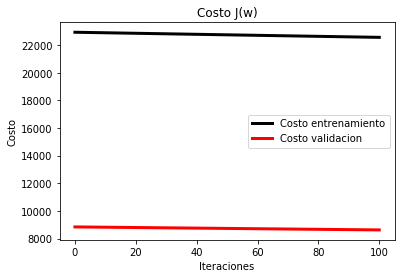

In [26]:
#Graficamos el costo
it = np.linspace(0, num_iter, num_iter)
plt.figure()
plt.plot(it, j_train, "k", linewidth=3, label="Costo entrenamiento")
plt.plot(it, j_test, "r", linewidth=3, label="Costo validacion")
plt.title("Costo J(w)")
plt.xlabel('Iteraciones')
plt.ylabel('Costo') 
plt.legend()
plt.show()


In [27]:
#Ejemplo con umbral de 0.85
porcentaje=0.85
#Se calculan las predicciones de clases
val_preds=classify(w,x_test_norm_b,porcentaje)
print(type(val_preds))

<class 'list'>


In [28]:
#Las predicciones se convierten en vectores
val_preds = np.array(val_preds, dtype='float64')
val_preds = val_preds.reshape(val_preds.shape[0], 1)
print(val_preds.shape)


(5370, 1)


In [29]:
#Se calcula la matriz de confusión
confusion = confusion_matrix(y_test, val_preds)
print('Confusion matix\n',confusion)

#Se calculan las métricas de evaluación
accuracy=((confusion[0,0]+confusion[1,1])/(confusion[0,0]+confusion[0,1]+confusion[1,0]+confusion[1,1]))
precision=(confusion[1,1]/(confusion[1,1]+confusion[0,1]))
sensitivity=(confusion[1,1]/(confusion[1,1]+confusion[1,0]))
specificity=(confusion[0,0]/(confusion[0,0]+confusion[0,1]))
f1score=2*(precision*sensitivity)/(precision+sensitivity)

print('\nAcurracy:',accuracy)
print('Precision:',precision)
print('Sensitivity:',sensitivity)
print('Specificity:',specificity)
print('F1-score:',f1score)

Confusion matix
 [[4811   63]
 [  68  428]]

Acurracy: 0.9756052141527002
Precision: 0.8716904276985743
Sensitivity: 0.8629032258064516
Specificity: 0.9870742716454657
F1-score: 0.8672745694022289


In [30]:
#Se corre el algorítmo con diferentes umbrales
min_umbral=0.8
max_umbral=0.95
umbrals=101
umbral = np.linspace(min_umbral, max_umbral, umbrals)
logistic_accuracy=np.zeros(umbral.size-1)
logistic_precision=np.zeros(umbral.size-1)
logistic_sensitivity=np.zeros(umbral.size-1)
logistic_specificity=np.zeros(umbral.size-1)
logistic_f1score=np.zeros(umbral.size-1)
n=0

for i in range(1,101):
    porcentaje=umbral[i]
    val_preds=classify(w,x_test_norm_b,porcentaje)
    confusion_logistic = confusion_matrix(y_test, val_preds)
    
    
    logistic_accuracy[n]=((confusion_logistic[0,0]+confusion_logistic[1,1])/(confusion_logistic[0,0]+confusion_logistic[0,1]+confusion_logistic[1,0]+confusion_logistic[1,1]))
    logistic_precision[n]=(confusion_logistic[1,1]/(confusion_logistic[1,1]+confusion_logistic[0,1]))
    logistic_sensitivity[n]=(confusion_logistic[1,1]/(confusion_logistic[1,1]+confusion_logistic[1,0]))
    logistic_specificity[n]=(confusion_logistic[0,0]/(confusion_logistic[0,0]+confusion_logistic[0,1]))
    logistic_f1score[n]=(2*(logistic_precision[n]*logistic_sensitivity[n])/(logistic_precision[n]+logistic_sensitivity[n]))
    n+=1
    

In [31]:
print('TPR:\n',logistic_sensitivity)
print('\nFPR:\n',1-logistic_specificity)

TPR:
 [1.         1.         0.99798387 0.99596774 0.99395161 0.99395161
 0.99395161 0.99395161 0.9858871  0.9858871  0.98185484 0.97782258
 0.97580645 0.97177419 0.96572581 0.96169355 0.95766129 0.94758065
 0.94153226 0.93548387 0.92943548 0.92540323 0.92137097 0.91935484
 0.91733871 0.90927419 0.90725806 0.90120968 0.90120968 0.89314516
 0.88709677 0.88104839 0.86895161 0.86290323 0.85685484 0.85483871
 0.84274194 0.82862903 0.82459677 0.82056452 0.81451613 0.7983871
 0.78830645 0.78427419 0.77419355 0.77016129 0.76008065 0.74798387
 0.74193548 0.7358871  0.72983871 0.71572581 0.70766129 0.69758065
 0.68951613 0.6875     0.67540323 0.66129032 0.65120968 0.6391129
 0.63104839 0.62298387 0.61895161 0.61290323 0.60483871 0.59879032
 0.58467742 0.57258065 0.55846774 0.54637097 0.53427419 0.51814516
 0.51008065 0.50604839 0.49193548 0.47177419 0.45967742 0.45362903
 0.44354839 0.43548387 0.42741935 0.41129032 0.40524194 0.39112903
 0.36491935 0.35483871 0.34072581 0.3266129  0.3125     0.

Confusion matriz
 [[4724  150]
 [  49  447]]

Acurracy: 0.9629422718808194
Precision: 0.7487437185929648
Sensitivity: 0.9012096774193549
Specificity: 0.969224456298728
F1-score: 0.817932296431839

Optimal threshold: 0.842


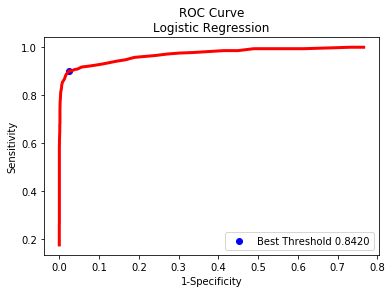

In [32]:
#Se obtiene el umbral óptimo
optimal_logistic_idx=np.argmax(logistic_sensitivity-(1-logistic_specificity))

optimal_logistic_threshold=umbral[optimal_logistic_idx]

#Utilizando el mejor umbral
porcentaje=umbral[optimal_logistic_idx]
#Se calculan las predicciones de clases
val_preds=classify(w,x_test_norm_b,porcentaje)

#Las predicciones se convierten en vectores
val_preds = np.array(val_preds, dtype='float64')
val_preds = val_preds.reshape(val_preds.shape[0], 1)

#Se calcula la matriz de confusión
confusion_best_logistic= confusion_matrix(y_test, val_preds)
print('Confusion matriz\n',confusion_best_logistic)

#Se calculan las métricas de evaluación
accuracy=((confusion_best_logistic[0,0]+confusion_best_logistic[1,1])/(confusion_best_logistic[0,0]+confusion_best_logistic[0,1]+confusion_best_logistic[1,0]+confusion_best_logistic[1,1]))
precision=(confusion_best_logistic[1,1]/(confusion_best_logistic[1,1]+confusion_best_logistic[0,1]))
sensitivity=(confusion_best_logistic[1,1]/(confusion_best_logistic[1,1]+confusion_best_logistic[1,0]))
specificity=(confusion_best_logistic[0,0]/(confusion_best_logistic[0,0]+confusion_best_logistic[0,1]))
f1score=2*(precision*sensitivity)/(precision+sensitivity)

print('\nAcurracy:',accuracy)
print('Precision:',precision)
print('Sensitivity:',sensitivity)
print('Specificity:',specificity)
print('F1-score:',f1score)

print('\nOptimal threshold:',optimal_logistic_threshold)

#Graficamos curva ROC con lo datos obtenidos
plt.figure()
plt.plot((1-logistic_specificity),logistic_sensitivity,"r", linewidth=3)
plt.scatter((1-logistic_specificity[optimal_logistic_idx]),logistic_sensitivity[optimal_logistic_idx], alpha = 1, color='b', label='Best Threshold {}'.format('%.4f' % umbral[optimal_logistic_idx]))
plt.title("ROC Curve\nLogistic Regression")
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity') 
plt.legend()
plt.show()

## Logistic Regression

In [33]:
#Utilizamos librerías para hacer el algorítmo de Logistic Regression con regularización de Lasso
y_train=np.ravel(y_train,order='C')
logistic=LogisticRegression(random_state=0,penalty='l1')
logistic.fit(x_train_norm, y_train)

C:\Users\Raul Gonzalez\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Confusion matrix
 [[4703  171]
 [  32  464]]

Acurracy: 0.9621973929236499
Precision: 0.7307086614173228
Sensitivity: 0.9354838709677419
Specificity: 0.9649158801805499
F1-score: 0.8205128205128205

Optimal threshold: 0.5319154518434702
AUC: 0.9794250598964882

Log loss: 1.3056812549957981


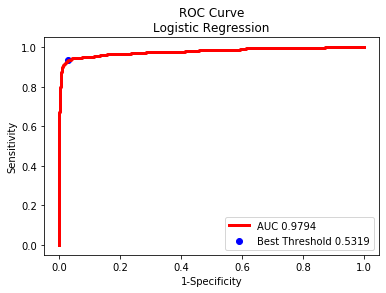

In [34]:
#Hacemos las predicciones
y_logistic_pred = logistic.predict(x_test_norm)

#Calculamos la matriz de confusión
confusion_logistic = confusion_matrix(y_test,y_logistic_pred)
print("Confusion matrix\n",confusion_logistic)

#Se calculan las métricas de evaluación
accuracy=((confusion_logistic[0,0]+confusion_logistic[1,1])/(confusion_logistic[0,0]+confusion_logistic[0,1]+confusion_logistic[1,0]+confusion_logistic[1,1]))
precision=(confusion_logistic[1,1]/(confusion_logistic[1,1]+confusion_logistic[0,1]))
sensitivity=(confusion_logistic[1,1]/(confusion_logistic[1,1]+confusion_logistic[1,0]))
specificity=(confusion_logistic[0,0]/(confusion_logistic[0,0]+confusion_logistic[0,1]))
f1score=2*(precision*sensitivity)/(precision+sensitivity)

print('\nAcurracy:',accuracy)
print('Precision:',precision)
print('Sensitivity:',sensitivity)
print('Specificity:',specificity)
print('F1-score:',f1score)


#Encontramos la probabilidad de las perdicciones que sea clase 1
y_logistic_pred_proba = logistic.predict_proba(x_test_norm)[:,1]

#Obtenemos el false positve rate y el true positive rate con librerías
fpr_logistic, tpr_logistic, thresholds_logistic = metrics.roc_curve(y_test,y_logistic_pred_proba)

#Calculamos el área bajo la curva ROC utilizando librerías
auc_logistic=skm.roc_auc_score(y_test,y_logistic_pred_proba)

#Se obtiene el umbral óptimo
optimal_thresholds_logistic_idx=np.argmax(tpr_logistic-fpr_logistic)

optimal_thresholds_logistic=thresholds_logistic[optimal_thresholds_logistic_idx]
print('\nOptimal threshold:',optimal_thresholds_logistic)
print('AUC:',auc_logistic)
logistic_loss = log_loss(y_test, y_logistic_pred)
print("\nLog loss:",logistic_loss)

#Graficamos la curva ROC utilizando librerías
plt.figure()
plt.plot(fpr_logistic, tpr_logistic,"r", linewidth=3, label='AUC {}'.format('%.4f' % auc_logistic))
plt.scatter((fpr_logistic[optimal_thresholds_logistic_idx]),tpr_logistic[optimal_thresholds_logistic_idx], alpha = 1, color='b', label='Best Threshold {}'.format('%.4f' % thresholds_logistic[optimal_thresholds_logistic_idx]))
plt.title("ROC Curve\nLogistic Regression")
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity') 
plt.legend()
plt.show()

In [35]:
#Utilizamos librerías para hacer el algorítmo de Logistic Regression con regularización de Ridge
logistic=LogisticRegression(random_state=0,penalty='l2')
logistic.fit(x_train_norm, y_train)

C:\Users\Raul Gonzalez\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Confusion matrix
 [[4675  199]
 [  38  458]]

Acurracy: 0.9558659217877095
Precision: 0.6971080669710806
Sensitivity: 0.9233870967741935
Specificity: 0.9591711120229791
F1-score: 0.7944492627927146

Optimal threshold: 0.45272743377738367
AUC: 0.9761530901293234

Log loss: 1.5243666900339747


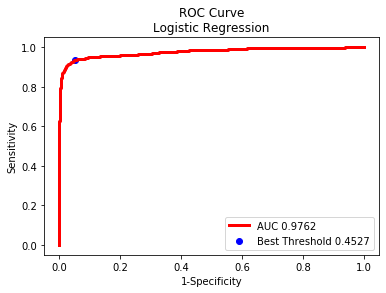

In [36]:
#Hacemos las predicciones
y_logistic_pred = logistic.predict(x_test_norm)

#Calculamos la matriz de confusión
confusion_logistic = confusion_matrix(y_test,y_logistic_pred)
print("Confusion matrix\n",confusion_logistic)

#Se calculan las métricas de evaluación
accuracy=((confusion_logistic[0,0]+confusion_logistic[1,1])/(confusion_logistic[0,0]+confusion_logistic[0,1]+confusion_logistic[1,0]+confusion_logistic[1,1]))
precision=(confusion_logistic[1,1]/(confusion_logistic[1,1]+confusion_logistic[0,1]))
sensitivity=(confusion_logistic[1,1]/(confusion_logistic[1,1]+confusion_logistic[1,0]))
specificity=(confusion_logistic[0,0]/(confusion_logistic[0,0]+confusion_logistic[0,1]))
f1score=2*(precision*sensitivity)/(precision+sensitivity)

print('\nAcurracy:',accuracy)
print('Precision:',precision)
print('Sensitivity:',sensitivity)
print('Specificity:',specificity)
print('F1-score:',f1score)


#Encontramos la probabilidad de las perdicciones que sea clase 1
y_logistic_pred_proba = logistic.predict_proba(x_test_norm)[:,1]

#Obtenemos el false positve rate y el true positive rate con librerías
fpr_logistic, tpr_logistic, thresholds_logistic = metrics.roc_curve(y_test,y_logistic_pred_proba)

#Calculamos el área bajo la curva ROC utilizando librerías
auc_logistic=skm.roc_auc_score(y_test,y_logistic_pred_proba)

#Se obtiene el umbral óptimo
optimal_thresholds_logistic_idx=np.argmax(tpr_logistic-fpr_logistic)

optimal_thresholds_logistic=thresholds_logistic[optimal_thresholds_logistic_idx]
print('\nOptimal threshold:',optimal_thresholds_logistic)
print('AUC:',auc_logistic)
logistic_loss = log_loss(y_test, y_logistic_pred)
print("\nLog loss:",logistic_loss)

#Graficamos la curva ROC utilizando librerías
plt.figure()
plt.plot(fpr_logistic, tpr_logistic,"r", linewidth=3, label='AUC {}'.format('%.4f' % auc_logistic))
plt.scatter((fpr_logistic[optimal_thresholds_logistic_idx]),tpr_logistic[optimal_thresholds_logistic_idx], alpha = 1, color='b', label='Best Threshold {}'.format('%.4f' % thresholds_logistic[optimal_thresholds_logistic_idx]))
plt.title("ROC Curve\nLogistic Regression")
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity') 
plt.legend()
plt.show()

## Support Vector Machine

In [37]:
#Definimos el kernel primero como lineal y entrenamos el modelo
svclassifier = SVC(kernel='linear', probability=True)
svclassifier.fit(x_train_norm, y_train)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

Confusion matrix
 [[4751  123]
 [  35  461]]

Acurracy: 0.9705772811918063
Precision: 0.7893835616438356
Sensitivity: 0.9294354838709677
Specificity: 0.9747640541649569
F1-score: 0.8537037037037037

Optimal threshold: 0.6031909244103996
AUC: 0.9779013809284287

Log loss: 1.0162430206480086


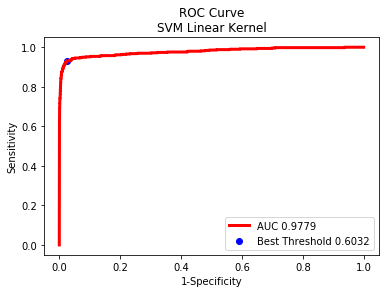

In [38]:
#Encontramos las predicciones
y_svm_pred = svclassifier.predict(x_test_norm)

#Calculamos la matriz de confusión
confusion_svm = confusion_matrix(y_test,y_svm_pred)
print("Confusion matrix\n",confusion_svm)

#Se calculan las métricas de evaluación
accuracy=((confusion_svm[0,0]+confusion_svm[1,1])/(confusion_svm[0,0]+confusion_svm[0,1]+confusion_svm[1,0]+confusion_svm[1,1]))
precision=(confusion_svm[1,1]/(confusion_svm[1,1]+confusion_svm[0,1]))
sensitivity=(confusion_svm[1,1]/(confusion_svm[1,1]+confusion_svm[1,0]))
specificity=(confusion_svm[0,0]/(confusion_svm[0,0]+confusion_svm[0,1]))
f1score=2*(precision*sensitivity)/(precision+sensitivity)

print('\nAcurracy:',accuracy)
print('Precision:',precision)
print('Sensitivity:',sensitivity)
print('Specificity:',specificity)
print('F1-score:',f1score)

#Encontramos la probabilidad de las perdicciones que sea clase 1
y_svm_pred_proba = svclassifier.predict_proba(x_test_norm)[:,1]

#Obtenemos el false positve rate y el true positive rate con librerías
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(y_test, y_svm_pred_proba)

#Calculamos el área bajo la curva ROC utilizando librerías
auc_svm=skm.roc_auc_score(y_test,y_svm_pred_proba)

#Se obtiene el umbral óptimo
optimal_thresholds_svm_idx=np.argmax(tpr_svm-fpr_svm)


optimal_thresholds_svm=thresholds_svm[optimal_thresholds_svm_idx]
print('\nOptimal threshold:',optimal_thresholds_svm)
print('AUC:',auc_svm)

svm_loss = log_loss(y_test, y_svm_pred)
print("\nLog loss:",svm_loss)

#Graficamos la curva ROC utilizando librerías
plt.figure()
plt.plot(fpr_svm, tpr_svm,"r", linewidth=3, label='AUC {}'.format('%.4f' % auc_svm))
plt.scatter((fpr_svm[optimal_thresholds_svm_idx]),tpr_svm[optimal_thresholds_svm_idx], alpha = 1, color='b', label='Best Threshold {}'.format('%.4f' % thresholds_svm[optimal_thresholds_svm_idx]))
plt.title("ROC Curve\nSVM Linear Kernel")
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()


In [39]:
#Definimos el kernel radial
svclassifier = SVC(kernel='rbf',probability=True)
svclassifier.fit(x_train_norm, y_train)

C:\Users\Raul Gonzalez\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

Confusion matrix
 [[4732  142]
 [  38  458]]

Acurracy: 0.9659408151870463
Precision: 0.7633333333333333
Sensitivity: 0.9233870967741935
Specificity: 0.9708658186294624
F1-score: 0.8357664233576643

Optimal threshold: 0.6213782934835108
AUC: 0.976768187353568

Log loss: 1.1577454923499098


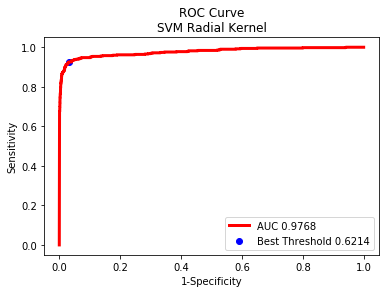

In [40]:
#Encontramos las predicciones
y_kernelsvm_pred = svclassifier.predict(x_test_norm)

#Encontramos la probabilidad de las perdicciones que sea clase 1
y_kernelsvm_pred_proba = svclassifier.predict_proba(x_test_norm)[:,1]

#Calculamos la matrix de confusión
confusion_kernelsvm = confusion_matrix(y_test,y_kernelsvm_pred)
print('Confusion matrix\n',confusion_kernelsvm)

#Se calculan las métricas de evaluación
accuracy=((confusion_kernelsvm[0,0]+confusion_kernelsvm[1,1])/(confusion_kernelsvm[0,0]+confusion_kernelsvm[0,1]+confusion_kernelsvm[1,0]+confusion_svm[1,1]))
precision=(confusion_kernelsvm[1,1]/(confusion_kernelsvm[1,1]+confusion_kernelsvm[0,1]))
sensitivity=(confusion_kernelsvm[1,1]/(confusion_kernelsvm[1,1]+confusion_kernelsvm[1,0]))
specificity=(confusion_kernelsvm[0,0]/(confusion_kernelsvm[0,0]+confusion_kernelsvm[0,1]))
f1score=2*(precision*sensitivity)/(precision+sensitivity)

print('\nAcurracy:',accuracy)
print('Precision:',precision)
print('Sensitivity:',sensitivity)
print('Specificity:',specificity)
print('F1-score:',f1score)


#Obtenemos el false positve rate y el true positive rate con librerías
fpr_kernelsvm, tpr_kernelsvm, thresholds_kernelsvm = metrics.roc_curve(y_test, y_kernelsvm_pred_proba)

#Calculamos el área bajo la curva ROC utilizando librerías
auc_kernelsvm=skm.roc_auc_score(y_test,y_kernelsvm_pred_proba)

#Se obtiene el umbral óptimo
optimal_thresholds_kernelsvm_idx=np.argmax(tpr_kernelsvm-fpr_kernelsvm)

optimal_thresholds_kernelsvm=thresholds_kernelsvm[optimal_thresholds_kernelsvm_idx]
print('\nOptimal threshold:',optimal_thresholds_kernelsvm)
print('AUC:',auc_kernelsvm)

svmkernel_loss = log_loss(y_test, y_kernelsvm_pred)
print("\nLog loss:",svmkernel_loss)

#Graficamos la curva ROC utilizando librerías
plt.figure()
plt.plot(fpr_kernelsvm, tpr_kernelsvm,"r", linewidth=3, label='AUC {}'.format('%.4f' % auc_kernelsvm))
plt.scatter((fpr_kernelsvm[optimal_thresholds_kernelsvm_idx]),tpr_kernelsvm[optimal_thresholds_kernelsvm_idx], alpha = 1, color='b', label='Best Threshold {}'.format('%.4f' % thresholds_kernelsvm[optimal_thresholds_kernelsvm_idx]))
plt.title("ROC Curve\nSVM Radial Kernel")
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity') 
plt.legend()
plt.show()

## K Nearest Neighbors

Confusion atrix
 [[4569  305]
 [  38  458]]

Acurracy: 0.9361266294227188
Precision: 0.6002621231979031
Sensitivity: 0.9233870967741935
Specificity: 0.9374230611407468
F1-score: 0.7275615567911041

Optimal threshold: 0.8
AUC: 0.9558273740188227

Log loss: 2.206153478709605


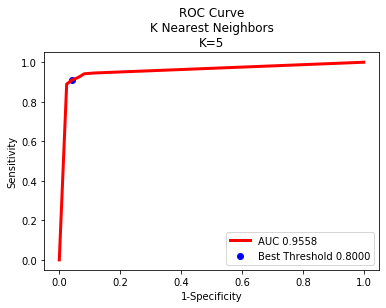

In [41]:
#Primero entrenamos el modelo con un valor de k=5
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(x_train_norm,y_train)

#Encontramos las predicciones para KNN con 5 neighbors
y_KNN_pred = KNN.predict(x_test_norm)
#Encontramos la probabilidad de las perdicciones que sea clase 1
y_KNN_pred_proba = KNN.predict_proba(x_test_norm)[:,1]

#Calculamos la matrix de confusión
confusion_KNN = confusion_matrix(y_test,y_KNN_pred)
print('Confusion atrix\n',confusion_KNN)

#Se calculan las métricas de evaluación
accuracy=((confusion_KNN[0,0]+confusion_KNN[1,1])/(confusion_KNN[0,0]+confusion_KNN[0,1]+confusion_KNN[1,0]+confusion_KNN[1,1]))
precision=(confusion_KNN[1,1]/(confusion_KNN[1,1]+confusion_KNN[0,1]))
sensitivity=(confusion_KNN[1,1]/(confusion_KNN[1,1]+confusion_KNN[1,0]))
specificity=(confusion_KNN[0,0]/(confusion_KNN[0,0]+confusion_KNN[0,1]))
f1score=2*(precision*sensitivity)/(precision+sensitivity)

print('\nAcurracy:',accuracy)
print('Precision:',precision)
print('Sensitivity:',sensitivity)
print('Specificity:',specificity)
print('F1-score:',f1score)

#Obtenemos el false positve rate y el true positive rate con librerías
fpr_KNN, tpr_KNN, thresholds_KNN = metrics.roc_curve(y_test, y_KNN_pred_proba)

#Calculamos el área bajo la curva ROC utilizando librerías
auc_KNN=skm.roc_auc_score(y_test,y_KNN_pred_proba)

#Encontramos el umbral óptimo
optimal_thresholds_KNN_idx=np.argmax(tpr_KNN-fpr_KNN)

optimal_thresholds_KNN=thresholds_KNN[optimal_thresholds_KNN_idx]
print('\nOptimal threshold:',optimal_thresholds_KNN)
print('AUC:',auc_KNN)

KNN_loss = log_loss(y_test, y_KNN_pred)
print("\nLog loss:",KNN_loss)

#Graficamos la curva ROC utilizando librerías
plt.figure()
plt.plot(fpr_KNN, tpr_KNN,"r", linewidth=3, label='AUC {}'.format('%.4f' % auc_KNN))
plt.scatter((fpr_KNN[optimal_thresholds_KNN_idx]),tpr_KNN[optimal_thresholds_KNN_idx], alpha = 1, color='b', label='Best Threshold {}'.format('%.4f' % thresholds_KNN[optimal_thresholds_KNN_idx]))
plt.title("ROC Curve\nK Nearest Neighbors\nK=5")
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity') 
plt.legend()
plt.show()

In [42]:
#Encontramos el valor de k que maximice la el f1score

min_k=1
max_k=100
k=np.linspace(min_k, max_k, max_k)
KNN_precision=np.zeros(max_k)
KNN_sensitivity=np.zeros(max_k)
KNN_f1score=np.zeros(max_k)
n=0

for i in range (min_k,max_k+1):
    KNN = KNeighborsClassifier(n_neighbors=i)
    KNN.fit(x_train_norm,y_train)
    y_KNN_pred = KNN.predict(x_test_norm)
    confusion_KNN = confusion_matrix(y_test,y_KNN_pred)
    KNN_precision[n]=(confusion_KNN[1,1]/(confusion_KNN[1,1]+confusion_KNN[0,1]))
    KNN_sensitivity[n]=(confusion_KNN[1,1]/(confusion_KNN[1,1]+confusion_KNN[1,0]))
    KNN_f1score[n]=2*(KNN_precision[n]*KNN_sensitivity[n])/(KNN_precision[n]+KNN_sensitivity[n])
    n+=1
    
print(KNN_f1score)   

[0.75914894 0.78031634 0.73821138 0.76222597 0.72756156 0.75518672
 0.73902634 0.76142976 0.74110032 0.75833333 0.74774035 0.76754015
 0.75621891 0.76818951 0.75477972 0.77342419 0.7627829  0.77053345
 0.76254181 0.77380952 0.76703112 0.77910959 0.77288136 0.78111588
 0.77184054 0.77645051 0.77195946 0.77853492 0.77430262 0.7822374
 0.77403035 0.78156997 0.77468354 0.7826087  0.77533784 0.78194208
 0.77599324 0.78194208 0.77928693 0.7826087  0.77730737 0.78394535
 0.77862595 0.78090367 0.77561389 0.7802385  0.77862595 0.78327645
 0.77928693 0.7826087  0.7779661  0.78194208 0.77730737 0.77994902
 0.77834179 0.78098472 0.77966102 0.77994902 0.78032231 0.78098472
 0.77966102 0.78098472 0.77834179 0.78098472 0.77900085 0.78098472
 0.77834179 0.78032231 0.77900085 0.78098472 0.77966102 0.78098472
 0.78032231 0.78164826 0.78164826 0.78164826 0.78032231 0.78164826
 0.78032231 0.78098472 0.78098472 0.78297872 0.78098472 0.7812766
 0.77994902 0.7802385  0.77862595 0.77891156 0.7779661  0.780238

Mejor valor de K: 42


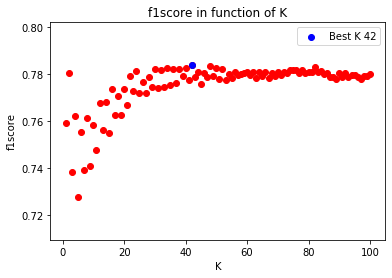

In [43]:
#Imprime el mejor número de k
k=np.array(k, dtype='int64')
print('Mejor valor de K:', k[KNN_f1score.argmax()])

#Graficamos el f1score en función del valor de k
plt.figure()
plt.scatter(k, KNN_f1score, alpha = 1, color='r')
plt.scatter(k[KNN_f1score.argmax()], KNN_f1score[KNN_f1score.argmax()], alpha = 1, color='b', label='Best K {}'.format('%d' % k[KNN_f1score.argmax()]))
plt.title("f1score in function of K")
plt.xlabel('K')
plt.ylabel('f1score') 
plt.legend()
plt.show()

Confusion matrix
 [[4658  216]
 [  37  459]]

Acurracy: 0.9528864059590316
Precision: 0.68
Sensitivity: 0.9254032258064516
Specificity: 0.9556832170701682
F1-score: 0.7839453458582408

Optimal threshold: 0.6428571428571429
AUC: 0.9710124574768025

Log loss: 1.627278052319801


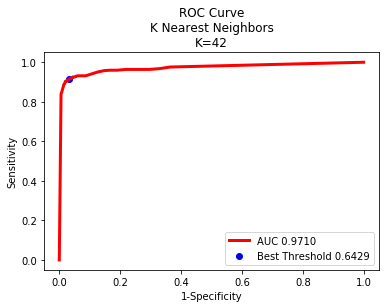

In [44]:
#Entrenamos el modelo con el mejor valor de K
KNN = KNeighborsClassifier(n_neighbors=k[KNN_f1score.argmax()])
KNN.fit(x_train_norm,y_train)

#Encontramos las predicciones y probabilidad de clase 1 para KNN con el valor de k que máximiza la precisión
y_KNN_pred = KNN.predict(x_test_norm)
y_KNN_pred_proba = KNN.predict_proba(x_test_norm)[:,1]

#Calculamos la matrix de confusión
confusion_KNN = confusion_matrix(y_test,y_KNN_pred)
print('Confusion matrix\n',confusion_KNN)

#Se calculan las métricas de evaluación
accuracy=((confusion_KNN[0,0]+confusion_KNN[1,1])/(confusion_KNN[0,0]+confusion_KNN[0,1]+confusion_KNN[1,0]+confusion_KNN[1,1]))
precision=(confusion_KNN[1,1]/(confusion_KNN[1,1]+confusion_KNN[0,1]))
sensitivity=(confusion_KNN[1,1]/(confusion_KNN[1,1]+confusion_KNN[1,0]))
specificity=(confusion_KNN[0,0]/(confusion_KNN[0,0]+confusion_KNN[0,1]))
f1score=2*(precision*sensitivity)/(precision+sensitivity)

print('\nAcurracy:',accuracy)
print('Precision:',precision)
print('Sensitivity:',sensitivity)
print('Specificity:',specificity)
print('F1-score:',f1score)

#Obtenemos el false positve rate y el true positive rate con librerías
fpr_KNN, tpr_KNN, thresholds_KNN = metrics.roc_curve(y_test, y_KNN_pred_proba)

#Calculamos el área bajo la curva ROC utilizando librerías
auc_KNN=skm.roc_auc_score(y_test,y_KNN_pred_proba)

#Encontramos el umbral óptimo
optimal_thresholds_KNN_idx=np.argmax(tpr_KNN-fpr_KNN)

optimal_thresholds_KNN=thresholds_KNN[optimal_thresholds_KNN_idx]
print('\nOptimal threshold:',optimal_thresholds_KNN)
print('AUC:',auc_KNN)

KNN_loss = log_loss(y_test, y_KNN_pred)
print("\nLog loss:",KNN_loss)

#Graficamos la curva ROC utilizando librerías
plt.figure()
plt.plot(fpr_KNN, tpr_KNN,"r", linewidth=3, label='AUC {}'.format('%.4f' % auc_KNN))
plt.scatter((fpr_KNN[optimal_thresholds_KNN_idx]),tpr_KNN[optimal_thresholds_KNN_idx], alpha = 1, color='b', label='Best Threshold {}'.format('%.4f' % thresholds_KNN[optimal_thresholds_KNN_idx]))
plt.title("ROC Curve\nK Nearest Neighbors\nK=42")
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity') 
plt.legend()
plt.show()

## Neural Networks

In [45]:
#Se crea el modelo
model = Sequential()

model.add(Dense(4, input_shape= (8,), activation ='sigmoid'))
model.add(Dense(2, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer= 'sgd', metrics = ['accuracy'])
class_weight = {0 : 1., 1 : 2.}
H = model.fit(x_train_norm,
                    y_train,
                    batch_size = 128,
                   epochs = 200,
                   class_weight=class_weight,
                   verbose = 0,
                   validation_data = (x_test_norm, y_test))

scores = model.evaluate(x_test_norm, y_test, verbose = 0)
#Se hacen las predicciones del modelo
predictions_proba = model.predict(x_test_norm, batch_size=128)
predictions = model.predict(x_test_norm, batch_size=128)
predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1
predictions=np.array(predictions, dtype='float64')

Confusion matrix
 [[4453  421]
 [  32  464]]

Acurracy: 0.9156424581005587
Precision: 0.5242937853107345
Sensitivity: 0.9354838709677419
Specificity: 0.9136233073450964
F1-score: 0.6719768283852281

Optimal threshold: 0.71408683
AUC 0.9735892887871126

Log loss: 2.913668964136435


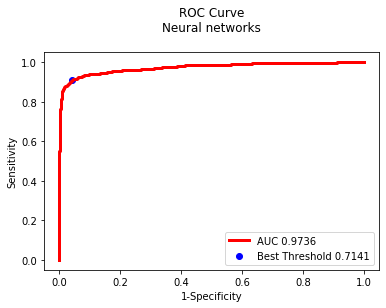

In [46]:
#Se calcula la matriz de confusión
confusion_NN= confusion_matrix(y_test, predictions)
print('Confusion matrix\n',confusion_NN)

#Se calculan las métricas de evaluación
accuracy=((confusion_NN[0,0]+confusion_NN[1,1])/(confusion_NN[0,0]+confusion_NN[0,1]+confusion_NN[1,0]+confusion_NN[1,1]))
precision=(confusion_NN[1,1]/(confusion_NN[1,1]+confusion_NN[0,1]))
sensitivity=(confusion_NN[1,1]/(confusion_NN[1,1]+confusion_NN[1,0]))
specificity=(confusion_NN[0,0]/(confusion_NN[0,0]+confusion_NN[0,1]))
f1score=2*(precision*sensitivity)/(precision+sensitivity)

print('\nAcurracy:',accuracy)
print('Precision:',precision)
print('Sensitivity:',sensitivity)
print('Specificity:',specificity)
print('F1-score:',f1score)

#Obtenemos el false positve rate y el true positive rate con librerías
fpr_NN, tpr_NN, thresholds_NN = metrics.roc_curve(y_test, predictions_proba)

#Calculamos el área bajo la curva ROC utilizando librerías
auc_NN=skm.roc_auc_score(y_test, predictions_proba)

#Encontramos el umbral óptimo
optimal_thresholds_NN_idx=np.argmax(tpr_NN-fpr_NN)

optimal_thresholds_NN=thresholds_NN[optimal_thresholds_NN_idx]
print('\nOptimal threshold:',optimal_thresholds_NN)
print('AUC',auc_NN)

NN_loss = log_loss(y_test, predictions)
print("\nLog loss:", NN_loss)

#Graficamos la curva ROC utilizando librerías
plt.figure()
plt.plot(fpr_NN, tpr_NN,"r", linewidth=3, label='AUC {}'.format('%.4f' % auc_NN))
plt.scatter((fpr_NN[optimal_thresholds_NN_idx]),tpr_NN[optimal_thresholds_NN_idx], alpha = 1, color='b', label='Best Threshold {}'.format('%.4f' % thresholds_NN[optimal_thresholds_NN_idx]))
plt.title("ROC Curve\nNeural networks\n")
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity') 
plt.legend()
plt.show()

## Random Forest


Confusion matrix
 [[4763  111]
 [  43  453]]

Acurracy: 0.9713221601489758
Precision: 0.8031914893617021
Sensitivity: 0.9133064516129032
Specificity: 0.9772260976610587
F1-score: 0.8547169811320755

Optimal threshold: 0.42
AUC: 0.977437679524005

Log loss: 0.9905140260951586


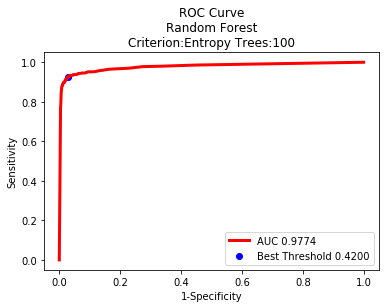

In [47]:
#Se crea el algoritmo utilizando el criterio de la entropía para la ganancia de información y 100 árboles 
RF = RandomForestClassifier(criterion='entropy', oob_score=True, random_state=1, n_estimators=100)
RF.fit(x_train_norm, y_train)

#Se realizan las predicciones, se encuentran las probabilidades y se calcula la matriz de confunsión
y_RF_pred = RF.predict(x_test_norm)
y_RF_pred_proba = RF.predict_proba(x_test_norm)[:,1]
confusion_RF=confusion_matrix(y_test, y_RF_pred)
print('Confusion matrix\n',confusion_RF)

#Se calculan las métricas de evaluación
accuracy=((confusion_RF[0,0]+confusion_RF[1,1])/(confusion_RF[0,0]+confusion_RF[0,1]+confusion_RF[1,0]+confusion_RF[1,1]))
precision=(confusion_RF[1,1]/(confusion_RF[1,1]+confusion_RF[0,1]))
sensitivity=(confusion_RF[1,1]/(confusion_RF[1,1]+confusion_RF[1,0]))
specificity=(confusion_RF[0,0]/(confusion_RF[0,0]+confusion_RF[0,1]))
f1score=2*(precision*sensitivity)/(precision+sensitivity)

print('\nAcurracy:',accuracy)
print('Precision:',precision)
print('Sensitivity:',sensitivity)
print('Specificity:',specificity)
print('F1-score:',f1score)

#Obtenemos el false positve rate y el true positive rate con librerías
fpr_RF, tpr_RF, thresholds_RF = metrics.roc_curve(y_test, y_RF_pred_proba)

#Calculamos el área bajo la curva ROC utilizando librerías
auc_RF=skm.roc_auc_score(y_test,y_RF_pred_proba)

#Encontramos el umbral óptimo
optimal_thresholds_RF_idx=np.argmax(tpr_RF-fpr_RF)


optimal_thresholds_RF=thresholds_RF[optimal_thresholds_RF_idx]
print('\nOptimal threshold:',optimal_thresholds_RF)
print('AUC:',auc_RF)

RF_loss = log_loss(y_test, y_RF_pred)
print("\nLog loss:", RF_loss)

#Graficamos la curva ROC utilizando librerías
plt.figure()
plt.plot(fpr_RF, tpr_RF,"r", linewidth=3, label='AUC {}'.format('%.4f' % auc_RF))
plt.scatter((fpr_RF[optimal_thresholds_RF_idx]),tpr_RF[optimal_thresholds_RF_idx], alpha = 1, color='b', label='Best Threshold {}'.format('%.4f' % thresholds_RF[optimal_thresholds_RF_idx]))
plt.title("ROC Curve\nRandom Forest\nCriterion:Entropy Trees:100")
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity') 
plt.legend()
plt.show()

Confusion matrix
 [[4768  106]
 [  43  453]]

Acurracy: 0.9722532588454376
Precision: 0.8103756708407871
Sensitivity: 0.9133064516129032
Specificity: 0.9782519491177677
F1-score: 0.8587677725118483

Optimal threshold: 0.35
AUC: 0.9775466762412803

Log loss: 0.9583542719123459


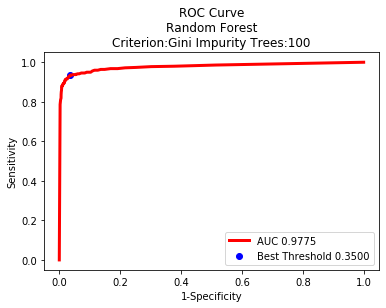

In [48]:
#Se crea el algoritmo utilizando el criterio del Gini impurity y 100 árboles 
RF = RandomForestClassifier(criterion='gini', oob_score=True, random_state=1, n_estimators=100)
RF.fit(x_train_norm, y_train)

#Se realizan las predicciones, se encuentran las probabilidades y se calcula la matriz de confunsión
y_RF_pred = RF.predict(x_test_norm)
y_RF_pred_proba = RF.predict_proba(x_test_norm)[:,1]
confusion_RF=confusion_matrix(y_test, y_RF_pred)

print('Confusion matrix\n',confusion_RF)

#Se calculan las métricas de evaluación
accuracy=((confusion_RF[0,0]+confusion_RF[1,1])/(confusion_RF[0,0]+confusion_RF[0,1]+confusion_RF[1,0]+confusion_RF[1,1]))
precision=(confusion_RF[1,1]/(confusion_RF[1,1]+confusion_RF[0,1]))
sensitivity=(confusion_RF[1,1]/(confusion_RF[1,1]+confusion_RF[1,0]))
specificity=(confusion_RF[0,0]/(confusion_RF[0,0]+confusion_RF[0,1]))
f1score=2*(precision*sensitivity)/(precision+sensitivity)

print('\nAcurracy:',accuracy)
print('Precision:',precision)
print('Sensitivity:',sensitivity)
print('Specificity:',specificity)
print('F1-score:',f1score)

#Obtenemos el false positve rate y el true positive rate con librerías
fpr_RF, tpr_RF, thresholds_RF = metrics.roc_curve(y_test, y_RF_pred_proba)

#Calculamos el área bajo la curva ROC utilizando librerías
auc_RF=skm.roc_auc_score(y_test,y_RF_pred_proba)

#Encontramos el umbral óptimo
optimal_thresholds_RF_idx=np.argmax(tpr_RF-fpr_RF)

optimal_thresholds_RF=thresholds_RF[optimal_thresholds_RF_idx]
print('\nOptimal threshold:',optimal_thresholds_RF)
print('AUC:',auc_RF)

RF_loss = log_loss(y_test, y_RF_pred)
print("\nLog loss:", RF_loss)

#Graficamos la curva ROC utilizando librerías
plt.figure()
plt.plot(fpr_RF, tpr_RF,"r", linewidth=3, label='AUC {}'.format('%.4f' % auc_RF))
plt.scatter((fpr_RF[optimal_thresholds_RF_idx]),tpr_RF[optimal_thresholds_RF_idx], alpha = 1, color='b', label='Best Threshold {}'.format('%.4f' % thresholds_RF[optimal_thresholds_RF_idx]))
plt.title("ROC Curve\nRandom Forest\nCriterion:Gini Impurity Trees:100")
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity') 
plt.legend()
plt.show()

In [49]:
#Se itera el número de árboles desde 64 hasta 128 utilizando ambos criterios de evaluación y escogiendo
#el modelo que tiene el mejor AUC

min_trees=64
max_trees=128
trees_range=(max_trees-min_trees)+1
trees = np.linspace(min_trees, max_trees, trees_range)

trees=np.array(trees, dtype='int64')

auc_RF_gini=np.zeros(trees_range)

auc_RF_entropy=np.zeros(trees_range)

n=0

for i in trees:
    RF = RandomForestClassifier(criterion='gini', oob_score=True, random_state=1, n_estimators=i)
    RF.fit(x_train_norm, y_train)
    y_RF_gini_pred_proba = RF.predict_proba(x_test_norm)[:,1]

    #Calculamos el área bajo la curva ROC utilizando librerías
    auc_RF_gini[n]=skm.roc_auc_score(y_test,y_RF_gini_pred_proba)
    n+=1
    
n=0

for i in trees:
    RF = RandomForestClassifier(criterion='entropy', oob_score=True, random_state=1, n_estimators=i)
    RF.fit(x_train_norm, y_train)
    y_RF_entropy_pred_proba = RF.predict_proba(x_test_norm)[:,1]

    #Calculamos el área bajo la curva ROC utilizando librerías
    auc_RF_entropy[n]=skm.roc_auc_score(y_test,y_RF_gini_pred_proba)
    n+=1


In [50]:
#Se imprimen los AUC y se encuentra el mayor
print(auc_RF_gini)
print(auc_RF_entropy)

print("\nMax AUC using Gini impurity: ",auc_RF_gini.max())
print("Max AUC using Entropy Information Gain: ",auc_RF_entropy.max())

#Finding the optimal number of trees
print("\nNumber of trees for highest AUC: ",trees[auc_RF_gini.argmax()])


[0.97773282 0.97786932 0.97782051 0.97776322 0.97766746 0.97758163
 0.97749683 0.97744326 0.97751813 0.97756839 0.97748132 0.97741762
 0.97749021 0.97738163 0.97734461 0.97728877 0.97722713 0.97720976
 0.97729704 0.97746457 0.9775171  0.97744471 0.97768752 0.97761886
 0.97757232 0.97752041 0.97757232 0.97753137 0.9774747  0.97746788
 0.97755102 0.9775231  0.97746726 0.97740914 0.9773897  0.97742796
 0.97754668 0.97750862 0.97755578 0.97754192 0.97749849 0.97747946
 0.9774565  0.97745753 0.9781171  0.97807946 0.97803127 0.9779808
 0.97794213 0.97791855 0.97799425 0.97796239 0.97815619 0.97813013
 0.97806663 0.97814337 0.97808132 0.97802879 0.97801617 0.978193
 0.97816736 0.97811689 0.97814068 0.97809518 0.97804554]
[0.97804554 0.97804554 0.97804554 0.97804554 0.97804554 0.97804554
 0.97804554 0.97804554 0.97804554 0.97804554 0.97804554 0.97804554
 0.97804554 0.97804554 0.97804554 0.97804554 0.97804554 0.97804554
 0.97804554 0.97804554 0.97804554 0.97804554 0.97804554 0.97804554
 0.97804

Confusion matrix
 [[4761  113]
 [  43  453]]

Acurracy: 0.9709497206703911
Precision: 0.8003533568904594
Sensitivity: 0.9133064516129032
Specificity: 0.9768157570783751
F1-score: 0.8531073446327683

Optimal threshold: 0.4146341463414634
AUC: 0.978193004023985

Log loss: 1.0033779277682837


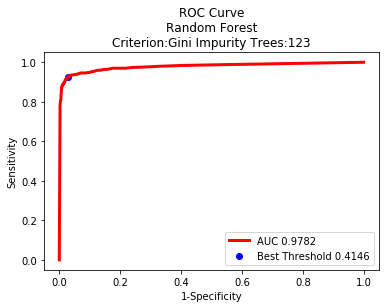

In [51]:
#Running algorithm with the criterion and n_estimators that yield the highest AUC
RF = RandomForestClassifier(criterion='gini', oob_score=True, random_state=1, n_estimators=trees[auc_RF_gini.argmax()])
RF.fit(x_train_norm, y_train)

y_RF_pred = RF.predict(x_test_norm)
y_RF_pred_proba = RF.predict_proba(x_test_norm)[:,1]
confusion_RF=confusion_matrix(y_test, y_RF_pred)

print('Confusion matrix\n',confusion_RF)

#Se calculan las métricas de evaluación
accuracy=((confusion_RF[0,0]+confusion_RF[1,1])/(confusion_RF[0,0]+confusion_RF[0,1]+confusion_RF[1,0]+confusion_RF[1,1]))
precision=(confusion_RF[1,1]/(confusion_RF[1,1]+confusion_RF[0,1]))
sensitivity=(confusion_RF[1,1]/(confusion_RF[1,1]+confusion_RF[1,0]))
specificity=(confusion_RF[0,0]/(confusion_RF[0,0]+confusion_RF[0,1]))
f1score=2*(precision*sensitivity)/(precision+sensitivity)

print('\nAcurracy:',accuracy)
print('Precision:',precision)
print('Sensitivity:',sensitivity)
print('Specificity:',specificity)
print('F1-score:',f1score)

#Obtenemos el false positve rate y el true positive rate con librerías
fpr_RF, tpr_RF, thresholds_RF = metrics.roc_curve(y_test, y_RF_pred_proba)

#Calculamos el área bajo la curva ROC utilizando librerías
auc_RF=skm.roc_auc_score(y_test,y_RF_pred_proba)

#Encontramos el umbral óptimo
optimal_thresholds_RF_idx=np.argmax(tpr_RF-fpr_RF)

optimal_thresholds_RF=thresholds_RF[optimal_thresholds_RF_idx]
print('\nOptimal threshold:',optimal_thresholds_RF)
print('AUC:',auc_RF)

RF_loss = log_loss(y_test, y_RF_pred)
print("\nLog loss:",RF_loss)

#Graficamos la curva ROC utilizando librerías
plt.figure()
plt.plot(fpr_RF, tpr_RF,"r", linewidth=3, label='AUC {}'.format('%.4f' % auc_RF))
plt.scatter((fpr_RF[optimal_thresholds_RF_idx]),tpr_RF[optimal_thresholds_RF_idx], alpha = 1, color='b', label='Best Threshold {}'.format('%.4f' % thresholds_RF[optimal_thresholds_RF_idx]))
plt.title("ROC Curve\nRandom Forest\nCriterion:Gini Impurity Trees:{0}".format(trees[auc_RF_gini.argmax()]))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity') 
plt.legend()
plt.show()